<a href="https://colab.research.google.com/github/linjikai/ai/blob/master/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [5]:
pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 11.5MB/s 


In [7]:
pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.6MB/s 
     |████████████████████████████████| 645kB 38.8MB/s 
     |████████████████████████████████| 174kB 39.7MB/s 
     |████████████████████████████████| 37.6MB 75kB/s 
     |████████████████████████████████| 706kB 31.8MB/s 
     |████████████████████████████████| 1.2MB 38.4MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 358kB 39.0MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [8]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [10]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
print(dataset_dir)
print(train_dir)
print(remove_dir)

./aclImdb
./aclImdb/train
./aclImdb/train/unsup


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [18]:
for text_batch, label_batch in train_ds.take(1):
  print(text_batch)
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

tf.Tensor(
[b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.'
 b"Icy and lethal ace hit-man Tony Arzenta (a divinely smooth and commanding performance by Alain Delon) wants to quit the assassination business, but the dangerous mobsters he works for won't let him. After his wife and child are killed, Arzenta declares open season on everyone responsible for their deaths. Director Duccio Tessari relates the absorbing story at a constant snappy pace, maintains a properly serious and no-nonsense tone throughout, stages the stirring shoot-outs and exciting car chases with considerable rip-snorting brio, an

In [36]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://hub.tensorflow.google.cn/tensorflow/albert_en_base/2',
    'electra_small':
        'https://hub.tensorflow.google.cn/google/electra_small/2',
    'electra_base':
        'https://hub.tensorflow.google.cn/google/electra_base/2',
    'experts_pubmed':
        'https://hub.tensorflow.google.cn/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://hub.tensorflow.google.cn/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://hub.tensorflow.google.cn/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://hub.tensorflow.google.cn/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://hub.tensorflow.google.cn/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Preprocess model auto-selected: https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3


In [37]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [38]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [40]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626287   0.9928097  -0.18611862  0.3667387   0.15233767  0.6550448
  0.9681154  -0.948627    0.00216148 -0.98777324  0.06842747 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300822  0.71020937
  -0.05771076]
 [-0.28741962  0.31980997 -0.23018558 ...  0.5845511  -0.21329674
   0.72692055]
 [-0.66156894  0.68876857 -0.87433094 ...  0.10877182 -0.26173127
   0.47855434]
 ...
 [-0.22561201 -0.28925633 -0.07064426 ...  0.4756598   0.83277243
   0.40025336]
 [-0.29824105 -0.27473113 -0.05450625 ...  0.48849684  1.0955372
   0.18163362]
 [-0.4437816   0.00930727  0.07223672 ...  0.17290097  1.1833246
   0.07898031]]


In [41]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [42]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.67710215]], shape=(1, 1), dtype=float32)


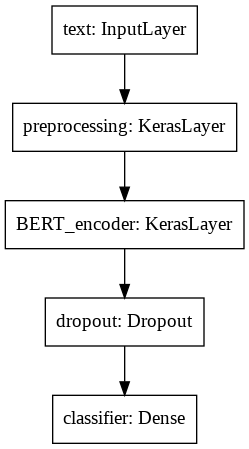

In [27]:
tf.keras.utils.plot_model(classifier_model)

In [45]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

3125


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [46]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus[0]

Num GPUs Available:  1


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [47]:
#tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Epoch 1/5
625/625 [==============================] - 282s 440ms/step - loss: 0.5777 - binary_accuracy: 0.6601 - val_loss: 0.3629 - val_binary_accuracy: 0.8366
Epoch 2/5
625/625 [==============================] - 273s 438ms/step - loss: 0.3566 - binary_accuracy: 0.8375 - val_loss: 0.3570 - val_binary_accuracy: 0.8486
Epoch 3/5
625/625 [==============================] - 274s 438ms/step - loss: 0.2701 - binary_accuracy: 0.8872 - val_loss: 0.3968 - val_binary_accuracy: 0.8538
Epoch 4/5
625/625 [==============================] - 274s 438ms/step - loss: 0.2049 - binary_accuracy: 0.9202 - val_loss: 0.4418 - val_binary_accuracy: 0.8530
Epoch 5/5
625/625 [==============================] - 274s 438ms/step - loss: 0.1567 - binary_accuracy: 0.9426 - val_loss: 0.4804 - val_binary_accuracy: 0.8520
